This is an early attempt at analyzing market sentiments using Webscraping. The script scrapes the r/wallstreetbets subreddit's
'What Are Your Moves' posts over the past 2 months and plots the sentiment of the subreddit against the movements of the S&P 500.

In [231]:
! pip install praw

In [232]:
! pip install pandas-datareader

In [441]:
import praw
from prawcore.exceptions import RequestException
import matplotlib.pyplot as plt
from matplotlib import style
from datetime import datetime, timedelta
import pandas_datareader.data as web

In [277]:
CLIENT_ID = 'UJjmN-ZQ55bhBQ'
CLIENT_SECRET = 'iEYpDNPE1lhbJBGlDrqfp49wOv4'
USER_AGENT = 'RedditScraper'
USERNAME = ''
PASSWORD = ''

In [278]:
reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET,
                     password=PASSWORD,
                     user_agent=USER_AGENT, username=USERNAME)

In [443]:
subreddit = reddit.subreddit('wallstreetbets')
posts = []
searchQuery = subreddit.search('Daily Discussion Thread',sort='new',time_filter='month')
while True:
    try:
        for post in searchQuery:
            if post.title.find('What Are Your Moves') != -1:
                posts.append(post)
                post.comments.replace_more(limit=0)
        break
    except RequestException:
       pass

In [444]:
ratios = []
dates = []
for post in posts:
    dt = datetime.fromtimestamp(post.created_utc)
    bull = 0
    bear = 0
    for comment in post.comments.list():
        try:
            if comment.body.lower().find('call' or 'calls' or 'up' or 'buy') != -1:
                bull += comment.score
            if comment.body.lower().find('put' or 'puts' or 'down' or 'sell') != -1:
                bear += comment.score
        except AttributeError:
            continue
    if(dt.day != datetime.now().day):
        ratios.append(bull/bear)
        if((dt.month % 2 == 1 or dt.month == 8) and dt.month < 9):
            dates.append(dt.month + dt.day/31)
        elif(dt.month == 2):
            dates.append(dt.month + dt.day/29)
        else:
            dates.append(dt.month + dt.day/30)
    

In [455]:
start = datetime.fromtimestamp(posts[-1].created_utc)
end = datetime.fromtimestamp(posts[0].created_utc) + timedelta(days=2)
sp = web.DataReader('SPY','yahoo', start, end)
sp = sp['Open']
sp = sp.iloc[::-1]

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Date')]

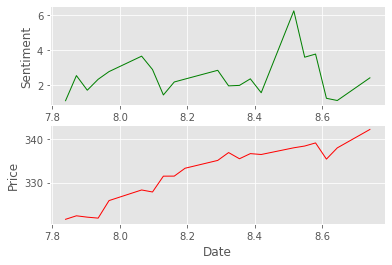

In [457]:
fig,a = plt.subplots(2)
style.use('ggplot')
a[0].plot(dates, ratios, 'g', linewidth=1.0)
a[0].set(ylabel='Sentiment')
a[1].plot(dates, sp, 'r', linewidth = 1)
a[1].set(xlabel = 'Date', ylabel = 'Price')